# Robust boosted stumps. 
The notebook is partially based on the notebook from Wong and Kolter, 2018.

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/home/maksym/boost_github")
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches
import data
from stump_ensemble import StumpEnsemble
from tree_ensemble import TreeEnsemble
from classifiers import OneVsAllClassifier
from train import robust_boost
from utils import Logger

%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")
np.random.seed(1)


Training of `plain` model started.
[0-vs-all]: n_ex 20, n_coords 2 -- loss 1.00000->0.54774, b=0.235 wl=10.000 wr=-10.602 at coord 1
starting evaluation (0.00s)
iter: 1 [test] err 15.00% adv_err_lb 30.00% adv_err 30.00% adv_err_ub 30.00% | [valid] err 15.00% adv_err 30.00% | [train] err 15.00% adv_err 30.00% loss 0.54774 |  (0.835s, 0.000s)
[0-vs-all]: n_ex 20, n_coords 2 -- loss 0.54774->0.00485, b=0.783 wl=-4.726 wr=10.000 at coord 0
starting evaluation (0.84s)
iter: 2 [test] err 0.00% adv_err_lb 25.00% adv_err 25.00% adv_err_ub 25.00% | [valid] err 0.00% adv_err 25.00% | [train] err 0.00% adv_err 25.00% loss 0.00485 |  (0.841s, 0.000s)
[0-vs-all]: n_ex 20, n_coords 2 -- loss 0.00485->0.00315, b=0.783 wl=-0.431 wr=10.000 at coord 0
starting evaluation (0.84s)
iter: 3 [test] err 0.00% adv_err_lb 25.00% adv_err 25.00% adv_err_ub 25.00% | [valid] err 0.00% adv_err 25.00% | [train] err 0.00% adv_err 25.00% loss 0.00315 |  (0.847s, 0.000s)
[0-vs-all]: n_ex 20, n_coords 2 -- loss 0.00315->

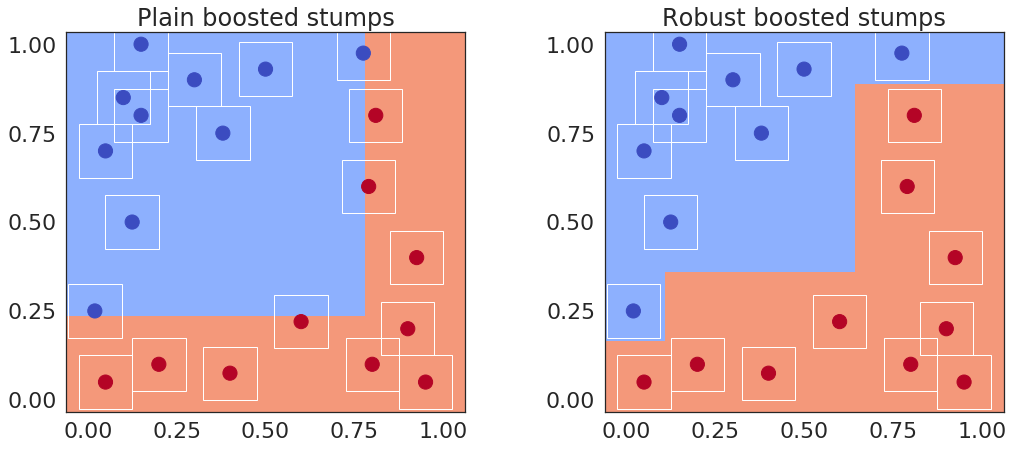

In [3]:
def plot_grid(ensemble, ax):
    grid_size = 1000
    XX, YY = np.meshgrid(np.linspace(-0.1, 1.1, grid_size), np.linspace(-0.1, 1.1, grid_size))
    X0 = np.stack([np.ravel(XX), np.ravel(YY)]).T
    y_pred = ensemble.predict(X0)
    ZZ = y_pred.reshape(grid_size, grid_size)
    
    # reflects just class assignment
    ax.contourf(XX,YY,ZZ, cmap="coolwarm", levels=np.linspace(-1000, 1000, 3))
    # reflects the classifier's predictions
    # ax.contourf(XX,YY,ZZ, cmap="coolwarm", levels=np.linspace(-np.abs(y_pred).max(),np.abs(y_pred).max(),10))
    ax.scatter(X[:,0], X[:,1], c=y.flatten(), cmap="coolwarm", s=200)
    ax.axis("equal")
    axis_margin = 0.035
    ax.set_xlim([-axis_margin, 1.0+axis_margin])
    ax.set_ylim([-axis_margin, 1.0+axis_margin])

    for x in X:
        rect_center = (x[0]-eps_dataset, x[1]-eps_dataset)
        rect = patches.Rectangle(rect_center, 2*eps_dataset, 2*eps_dataset, fill=False)
        ax.add_patch(rect)
    
    ticks = [0.0, 0.25, 0.5, 0.75, 1.0]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_title(model_name)

weak_learner = 'stump'
dataset = 'toy_2d_{}s'.format(weak_learner)  # toy_2d_trees, toy_2d_xor, toy_2d_wong
X, y, eps_dataset = data.all_datasets_dict[dataset]()
X = data.convert_to_float32(X)
y, _, _ = data.transform_labels_one_vs_all(y, y, y)

models_names = ['Plain boosted {}s'.format(weak_learner), 
                'Robust boosted {}s'.format(weak_learner)]
if weak_learner == 'stump':
    models = ['plain', 'robust_exact']
elif weak_learner == 'tree':
    models = ['plain', 'robust_bound']
else:
    raise ValueError('wrong weak learner')
# models = ['plain', 'robust_bound', 'robust_exact']
for n_iter in [7]:
    np.random.seed(1)
    fig, axs = plt.subplots(1, len(models), figsize=(1.2*len(models)*7, 7))
    for i, (model, model_name) in enumerate(zip(models, models_names)):
        print('Training of `{}` model started.'.format(model))
        eps, eps_eval = eps_dataset, eps_dataset
        # n_iter, lr = 2, 1.0
        lr = 1.0
        log, model_path, metrics_path = Logger(''), '', ''  # nothing will be saved
        
        if weak_learner == 'stump':
            ensemble = StumpEnsemble('stump', 2, lr, 0, -1, 10.0)
        elif weak_learner == 'tree':
            depth_trees = 5
            ensemble = TreeEnsemble('tree', 2, lr, 1, 0, 0, depth_trees, 0, -1, 10.0)
        else:
            raise ValueError('wrong weak learner')
        model_ova = OneVsAllClassifier([ensemble])
        
        robust_boost(model_ova, X, y, X, y, X, y, weak_learner, n_iter, eps,
                     eps_eval, 10, False, model, log, model_path, metrics_path, False)
        plot_grid(model_ova, axs[i])
        print('\n')
    fig.subplots_adjust(wspace=0.35)
    plt.savefig('plots/plain_robust_{}.png'.format(dataset), bbox_inches='tight')
